In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.ar_model as ar
import torch
torch.set_default_dtype(torch.double)
import sigkernel

In [2]:
import scipy.stats as stats

In [3]:
from tqdm import tqdm

In [4]:
from itertools import product

In [5]:
RNG = np.random.default_rng(1234)

In [6]:
def gen_ar_process(n, a = 0.8):
    z = RNG.binomial(1, [1/2], n)
    x = torch.zeros(n)

    x[0] = z[0]
    a = 0.8
    for i, zi in enumerate(z[1:]):
        x[i+1] = a*x[i] + zi 
        
    return x

In [7]:
def gen_long_samples():
    x_long = gen_ar_process(6001)
    x_long_samples = torch.zeros(60, 100, 2)
    for i in range(60):
        x_long_samples[i, :, 0] = x_long[100*i + 1:100*(i+1) + 1]
        x_long_samples[i, :, 1] = x_long[100*i:100*(i+1)]
    return x_long_samples

In [8]:
def gen_long_samples_burn_in():
    x_long = gen_ar_process(12001)
    x_long_samples = torch.zeros(60, 100, 2)
    for i in range(60):
        x_long_samples[i, :, 0] = x_long[5999+100*i + 1:5999+100*(i+1) + 1]
        x_long_samples[i, :, 1] = x_long[5999+100*i:5999+100*(i+1)]
    return x_long_samples

In [9]:
def gen_short_samples():
    x_short_samples = torch.zeros(60, 100, 2)
    for i in range(60):
        process = gen_ar_process(101)
        x_short_samples[i, :, 0] = process[1:]
        x_short_samples[i, :, 1] = process[:-1]
    return x_short_samples

In [10]:
def gen_short_samples_burn_in():
    x_short_samples = torch.zeros(60, 100, 2)
    for i in range(60):
        process = gen_ar_process(6000)
        x_short_samples[i, :, 0] = process[-100:]
        x_short_samples[i, :, 1] = process[-101:-1]
    return x_short_samples

In [13]:
def get_gram_matrices(X, Y, dyadic_order = 1, static_kernel = sigkernel.RBFKernel(sigma=0.5)):
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
    n = X.shape[0]
    
    gram_x = torch.zeros(n,n)
    gram_y = torch.zeros(n,n)
    
    for i, j in product(range(n), range(n)):
        gram_x[i, j] = signature_kernel.compute_kernel(X[i:i+1, :,], X[j:j+1, :, :])
        gram_y[i, j] = signature_kernel.compute_kernel(Y[i:i+1, :,], Y[j:j+1, :, :])
        
    return gram_x, gram_y

In [14]:
scores = []
short_means = []
long_means = []

In [114]:
set_diag_to_zero = torch.ones(60, 60) - torch.diag_embed(torch.ones(60))

for i in range(100):
    gram_short, gram_long = get_gram_matrices(gen_short_samples(), gen_long_samples())
    
    kernel_short_mean = (gram_short*set_diag_to_zero).sum()/(100*99)
    kernel_long_mean = (gram_long*set_diag_to_zero).sum()/(100*99)
    
    short_means.append(kernel_short_mean.item())
    long_means.append(kernel_long_mean.item())
    
    scores.append(kernel_short_mean - kernel_long_mean)

(array([1.08963508e-12, 7.62744557e-12, 7.62744557e-12, 1.85237964e-11,
        1.63445262e-11, 8.71708066e-12, 1.52548911e-11, 1.08963508e-11,
        3.26890525e-12, 6.53781049e-12, 4.35854033e-12, 0.00000000e+00,
        2.17927016e-12, 1.08963508e-12, 3.26890525e-12, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.08963508e-12, 1.08963508e-12]),
 array([1.76077524e+10, 2.67851367e+10, 3.59625211e+10, 4.51399055e+10,
        5.43172899e+10, 6.34946743e+10, 7.26720587e+10, 8.18494431e+10,
        9.10268275e+10, 1.00204212e+11, 1.09381596e+11, 1.18558981e+11,
        1.27736365e+11, 1.36913750e+11, 1.46091134e+11, 1.55268518e+11,
        1.64445903e+11, 1.73623287e+11, 1.82800671e+11, 1.91978056e+11,
        2.01155440e+11]),
 <BarContainer object of 20 artists>)

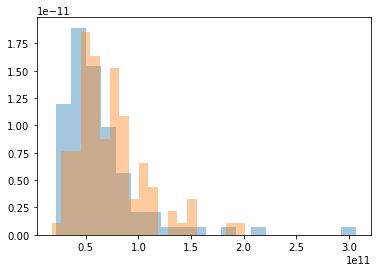

In [122]:
plt.hist(long_means, bins = 20, alpha = 0.4, density = True)
plt.hist(short_means, bins = 20, alpha = 0.4, density = True)

In [121]:
stats.ks_2samp(short_means, long_means)

KstestResult(statistic=0.23, pvalue=0.009878183186176536)

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  2.,  8., 17., 19., 27.,  9., 10.,
         4.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-2.08666527e+11, -1.86173906e+11, -1.63681285e+11, -1.41188665e+11,
        -1.18696044e+11, -9.62034232e+10, -7.37108025e+10, -5.12181818e+10,
        -2.87255610e+10, -6.23294031e+09,  1.62596804e+10,  3.87523011e+10,
         6.12449219e+10,  8.37375426e+10,  1.06230163e+11,  1.28722784e+11,
         1.51215405e+11,  1.73708026e+11,  1.96200646e+11,  2.18693267e+11,
         2.41185888e+11]),
 <BarContainer object of 20 artists>)

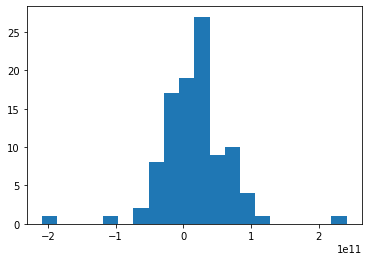

In [74]:
scores_numerical = [score.item() for score in scores]
plt.hist(scores_numerical, bins = 20)

In [87]:
gram_short, gram_long = get_gram_matrices(gen_short_samples_burn_in(), gen_long_samples_burn_in())
    
kernel_short_mean = (gram_short*set_diag_to_zero).sum()/(100*99)
kernel_long_mean = (gram_long*set_diag_to_zero).sum()/(100*99)


3600it [00:09, 397.34it/s]


In [88]:
print(kernel_short_mean)
print(kernel_long_mean)

tensor(8.0637e+10)
tensor(9.4266e+10)


In [104]:
scores_burn_in = []
short_means_burn_in = []
long_means_burn_in = []
set_diag_to_zero = torch.ones(60, 60) - torch.diag_embed(torch.ones(60))

for i in tqdm(range(100)):
    gram_short, gram_long = get_gram_matrices(gen_short_samples_burn_in(), gen_long_samples_burn_in())
    
    kernel_short_mean = (gram_short*set_diag_to_zero).sum()/(100*99)
    kernel_long_mean = (gram_long*set_diag_to_zero).sum()/(100*99)
    
    short_means_burn_in.append(kernel_short_mean.item())
    long_means_burn_in.append(kernel_long_mean.item())
    
    scores_burn_in.append(kernel_short_mean - kernel_long_mean)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [22:28<00:00, 13.48s/it]


(array([2.05135377e-12, 1.02567688e-11, 1.94878608e-11, 1.74365070e-11,
        1.84621839e-11, 1.23081226e-11, 3.07703065e-12, 9.23109196e-12,
        3.07703065e-12, 2.05135377e-12, 1.02567688e-12, 1.02567688e-12,
        1.02567688e-12, 1.02567688e-12, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.02567688e-12]),
 array([1.49196943e+10, 2.46693534e+10, 3.44190125e+10, 4.41686716e+10,
        5.39183308e+10, 6.36679899e+10, 7.34176490e+10, 8.31673082e+10,
        9.29169673e+10, 1.02666626e+11, 1.12416286e+11, 1.22165945e+11,
        1.31915604e+11, 1.41665263e+11, 1.51414922e+11, 1.61164581e+11,
        1.70914240e+11, 1.80663899e+11, 1.90413559e+11, 2.00163218e+11,
        2.09912877e+11]),
 <BarContainer object of 20 artists>)

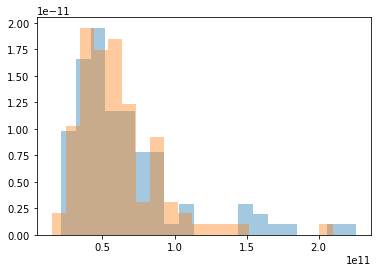

In [123]:
scores_numerical = [score.item() for score in scores_burn_in]
plt.hist(long_means_burn_in, bins = 20, alpha = 0.4, density = True)
plt.hist(short_means_burn_in, bins = 20, alpha = 0.4, density = True)


In [124]:
stats.ks_2samp(short_means_burn_in, long_means_burn_in)

KstestResult(statistic=0.09, pvalue=0.8154147124661313)

In [95]:
from pprint import PrettyPrinter

In [96]:
pp = PrettyPrinter(indent = 4)

In [98]:
print(kernel_short_mean)

tensor(7.4690e+10)


(array([ 1.,  2.,  3., 16., 20., 16., 22., 15.,  3.,  2.]),
 array([-137.92521485, -112.30553599,  -86.68585713,  -61.06617827,
         -35.44649941,   -9.82682055,   15.79285831,   41.41253717,
          67.03221603,   92.65189489,  118.27157375]),
 <BarContainer object of 10 artists>)

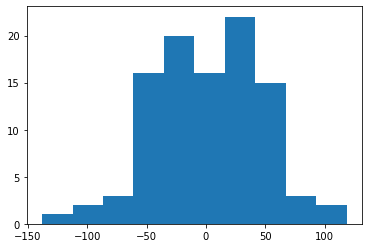

In [103]:
plt.hist([score/kernel_short_mean.item()*100 for score in sorted(scores_numerical)])